将原始数据转化为R、F、M属性值并输出为csv格式

In [ ]:
a=[]
import pandas as pd
import datetime #引入时间
data=pd.read_excel(r'RFM_Processed.xlsx')  #数据是世纪联华超市6.1-7.30两个月的顾客购物明细

users=data.groupby(['Member_id'])   #按照id划分出用户信息
f=users.XPBH.unique()     #统计每个用户的小票
f=f.apply(lambda x:len(x))  #统计每个用户的小票数，apply函数就是多次执行此操作，lambda函数类似于遍历的意思）

m=users.Amount.sum() #统计每个用户的总购物金额

deadline=datetime.datetime.strptime('2019-08-01','%Y-%m-%d') #设置deadline为2019-08-01
r_value=users.Date.max() #求出每个id的最近购买时间
r=deadline-r_value   #日期两个相减，求出相差值
r=r.apply(lambda x:x.days) #取每个的天数

rfm=pd.DataFrame([r,f,m]).T
rfm.columns=['R','F','M','R_value','F_value','M_value']

rfm.to_csv(r'Cluster_Data.csv')

利用手肘算法判定聚类数，聚3类比较合理

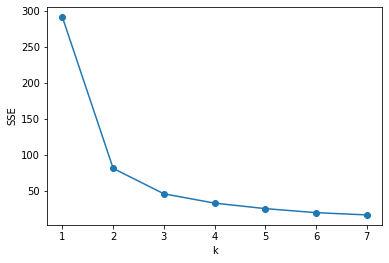

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
data=pd.read_csv(r'Cluster_data.csv')

r=data['R']
f=data['F']
m=data['M']
r_zs=(r.max()-r)/(r.max()-r.min())
f_zs=(f-f.min())/(f.max()-f.min())
m_zs=(m-m.min())/(m.max()-m.min())
data_zs=pd.DataFrame(list(zip(r_zs,f_zs,m_zs)),columns=['R','F','M'])

#利用“手肘法”去判定分多少类比较合适
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
SSE = [] # 存放每次结果的误差平方和
for k in range(1,8): 
    estimator = KMeans(n_clusters=k) # 构造聚类器 
    estimator.fit(data_zs) 
    SSE.append(estimator.inertia_)
X = range(1,8)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()
# k=3时为手肘

普通Kmeans跑出来的轮廓系数

In [7]:
from sklearn import metrics
k=3
model=KMeans(n_clusters=3,max_iter=500)  #分为k类
model.fit(data_zs) #开始聚类
print("轮廓系数：", metrics.silhouette_score(data_zs,model.labels_, metric='euclidean'))

轮廓系数： 0.5438655372737887


SA-PSO函数优化初始聚类点

In [48]:
# coding: utf-8
import numpy as np
import pandas as pd
import random
import math
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

#导入初始数据包
data=pd.read_csv(r'Cluster_Data.csv',index_col=0)  
r=data['R']
f=data['F']
m=data['M']

#数据标准化
r_zs=(r.max()-r)/(r.max()-r.min())
f_zs=(f-f.min())/(f.max()-f.min())
m_zs=(m-m.min())/(m.max()-m.min())
data_zs=pd.DataFrame(list(zip(r_zs,f_zs,m_zs)),columns=['R','F','M'])
array=data_zs.values

# ----------------------PSO参数设置---------------------------------
class PSO():
    def __init__(self, pN, dim, max_iter):
        self.w = 0.8
        self.c1 = 2
        self.c2 = 2
        self.r1 = 0.6
        self.r2 = 0.3
        self.pN = pN  # 粒子数量
        self.dim = dim  # 搜索维度
        self.max_iter = max_iter  # 迭代次数
        self.X = np.zeros((self.pN, self.dim))  # 所有粒子的位置和速度
        self.V = np.zeros((self.pN, self.dim))
        self.pbest = np.zeros((self.pN, self.dim))  # 个体经历的最佳位置和全局最佳位置
        self.gbest = np.zeros((1, self.dim))
        self.p_fit = np.zeros(self.pN)  # 每个个体的历史最佳适应值
        self.fit = 10000  # 全局最佳适应值

    # ---------------------目标函数-----------------------------
    def function(self, Xi):
        total_dis=0
        for i in array:
            dis0=np.sqrt(np.dot(i-Xi[0:3],(i-Xi[0:3]).T))
            dis1=np.sqrt(np.dot(i-Xi[3:6],(i-Xi[3:6]).T))
            dis2=np.sqrt(np.dot(i-Xi[6:9],(i-Xi[6:9]).T))
            total_dis+=min(dis0,dis1,dis2)
        return total_dis

    # ---------------------初始化种群----------------------------------
    def init_Population(self):
        for i in range(self.pN):
            for j in range(self.dim):
                self.V[i][j] = random.uniform(-1, 1)
                self.X[i][j] = random.uniform(-1,1)
            self.pbest[i] = self.X[i]
            tmp = self.function(self.X[i])
            self.p_fit[i] = tmp
            if tmp < self.fit:
                self.fit = tmp
                self.gbest = self.X[i]

    # ----------------------更新粒子位置----------------------------------
                    
    def iterator(self):
        fitness = []
        for t in range(self.max_iter):
            for i in range(self.pN): # 更新gbest\pbest
                temp = self.function(self.X[i])
                x=self.X[i]+np.random.uniform(low=-0.5,high=0.5)
                new_value=self.function(x)
                if new_value<temp:  #利用模拟退火算法跳脱局部最优
                    self.X[i]=x
                    temp=new_value
                else:
                    #metropolis principle
                    p=math.exp(-(new_value-temp)/1000)
                    r=np.random.uniform(low=0,high=1)
                    if r<p:
                        self.X[i]=x
                        temp=new_value
                if temp < self.p_fit[i]:  # 更新个体最优
                    self.p_fit[i] = temp
                    self.pbest[i] = self.X[i]
                if self.p_fit[i] < self.fit:  # 更新全局最优
                    self.gbest = self.X[i]
                    self.fit = self.p_fit[i]
            for i in range(self.pN):
                self.V[i] = self.w * self.V[i] + self.c1 * self.r1 * (self.pbest[i] - self.X[i]) + \
                            self.c2 * self.r2 * (self.gbest - self.X[i])
                self.V[i]=np.where(self.V[i]>1,1,self.V[i])
                self.V[i]=np.where(self.V[i]<0,0,self.V[i])
                self.X[i] = self.X[i] + self.V[i]
            fitness.append(self.fit)   # 存储每次迭代的最小距离
            print('总距离','\n',fitness)
            print('当前最小距离为',self.fit)
            print('当前最优粒子群组为',self.gbest)
        return fitness

        # ----------------------程序执行-----------------------


my_pso = PSO(pN=30, dim=9, max_iter=100)
my_pso.init_Population()
fitness = my_pso.iterator()



        # ----------------------画图-----------------------

总距离 
 [1015.5341183093024]
当前最小距离为 1015.5341183093024
当前最优粒子群组为 [ 0.65162898 -0.24692747  0.50062957  0.86132037  0.67026353  0.97249014
  0.41456983 -0.51775823 -0.19462255]
总距离 
 [1015.5341183093024, 924.7395844320008]
当前最小距离为 924.7395844320008
当前最优粒子群组为 [0.82266927 0.03391976 0.9511215  0.89024913 1.72598749 1.20707984
 0.82881661 0.33830367 0.66314794]
总距离 
 [1015.5341183093024, 924.7395844320008, 924.7395844320008]
当前最小距离为 924.7395844320008
当前最优粒子群组为 [0.82266927 0.03391976 0.9511215  0.89024913 1.72598749 1.20707984
 0.82881661 0.33830367 0.66314794]
总距离 
 [1015.5341183093024, 924.7395844320008, 924.7395844320008, 924.7395844320008]
当前最小距离为 924.7395844320008
当前最优粒子群组为 [0.82266927 0.03391976 0.9511215  0.89024913 1.72598749 1.20707984
 0.82881661 0.33830367 0.66314794]
总距离 
 [1015.5341183093024, 924.7395844320008, 924.7395844320008, 924.7395844320008, 924.7395844320008]
当前最小距离为 924.7395844320008
当前最优粒子群组为 [0.82266927 0.03391976 0.9511215  0.89024913 1.72598749 1.20707984
 0.8288166

输出适应度函数变化曲线

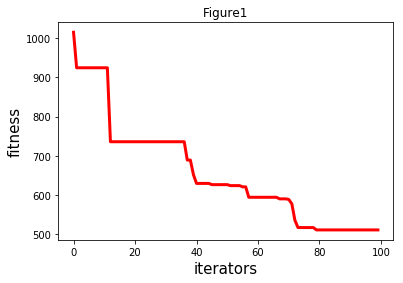

In [49]:
plt.figure()
plt.title("Figure1")
plt.xlabel("iterators", size=15)
plt.ylabel("fitness", size=15)
t = np.array([t for t in range(0, 100)])
fitness = np.array(fitness)
plt.plot(t, fitness, color='r', linewidth=3)
plt.show()

输出新模型的轮廓系数

In [50]:
model=KMeans(n_clusters=3,max_iter=500,init=np.array([my_pso.gbest[0:3],my_pso.gbest[3:6],my_pso.gbest[6:9]]),n_init=1)  
model.fit(data_zs) #开始聚类

print("轮廓系数：", metrics.silhouette_score(data_zs,model.labels_, metric='euclidean'))

轮廓系数： 0.6470120320864738
